## Notebook focus sur l'observation de la DATA

Dans ce notebook je reprend une solution proposée par un utilisateur Kaggle, pour la compétition Spaceship Titanic.
Cette solution se concentre beaucoup sur un aspect que je ne réalise pas du tout jusqu'a présent : **l'observation de la data**.

Pourtant il est essentiel de bien savoir observer ce qu'on étudie, pour en tirer le plus d'informations possibles et etre bien plus efficace après.

Je vais donc reprendre son notebook, pour comprendre les méthodes employées.
*Ce notebook servira plus tard pour les prochains projets.*

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [32]:
import seaborn as sns 
print("Seaborn version: ", sns.__version__)
sns.set(style="darkgrid", font_scale=1.4)
from imblearn.over_sampling import SMOTE
import itertools
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")
import plotly.express as px
import time

Seaborn version:  0.13.2


In [33]:
# Sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay, roc_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.utils.metaestimators import available_if
from sklearn.utils import resample

# Models
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB

Tous les imports sont réalisés, commencons les choses sérieuses

In [34]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

print("Train Set shape:", train.shape)
print("Test Set shape:", test.shape)
train.head()

Train Set shape: (8693, 14)
Test Set shape: (4277, 13)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [35]:
print("Train Set Missing Values:\n", train.isnull().sum())
print("\n")
print("Test Set Missing Values:\n", test.isnull().sum())

Train Set Missing Values:
 PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64


Test Set Missing Values:
 PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64


Quasiment toutes les features ont des données manquantes. Il va donc falloir impute tout ca, ou trouver une autre solution.

In [36]:
print(f'Duplicates in Train Set: {train.duplicated().sum()}, ({round(train.duplicated().sum()/len(train)*100, 1)}%)')
print(f'Duplicates in Test Set: {test.duplicated().sum()}, ({round(test.duplicated().sum()/len(test)*100, 1)}%)')

Duplicates in Train Set: 0, (0.0%)
Duplicates in Test Set: 0, (0.0%)


In [37]:
nunique = train.nunique()
dtypes = train.dtypes
summary_df = pd.DataFrame({"Nunique": nunique, "Dtypes": dtypes})
print(summary_df)

              Nunique   Dtypes
PassengerId      8693   object
HomePlanet          3   object
CryoSleep           2   object
Cabin            6560   object
Destination         3   object
Age                80  float64
VIP                 2   object
RoomService      1273  float64
FoodCourt        1507  float64
ShoppingMall     1115  float64
Spa              1327  float64
VRDeck           1306  float64
Name             8473   object
Transported         2     bool


Il va nous falloir transformer la data en numerique (int/foat), les modèles ne marchant pas sur des objets.
Il existe aussi des features avec une très grande cardinalité. D'habitude, on se débarasse de ces features pour ne pas s'embeter mais on verra plus loin que l'on peut les exploiter.

#### Explorons désormais le DataSet

Text(0.5, 1.0, 'Transported')

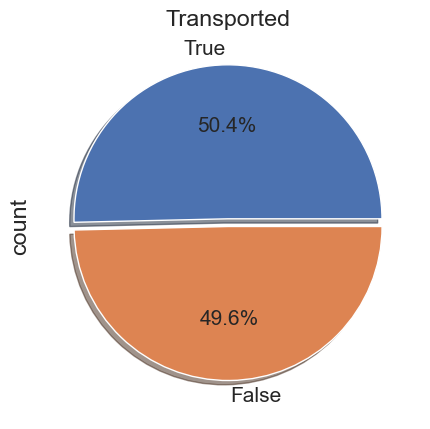

In [38]:
plt.figure(figsize=(5,5))
train['Transported'].value_counts().plot.pie(autopct='%1.1f%%', 
explode=[0.05,0], shadow=True, textprops={'fontsize': 15}).set_title('Transported')

La cible est très équilibrée, donc par chance nous n'avons pas à considérer de technique *d'under/oversampling*

##### Continuous Data

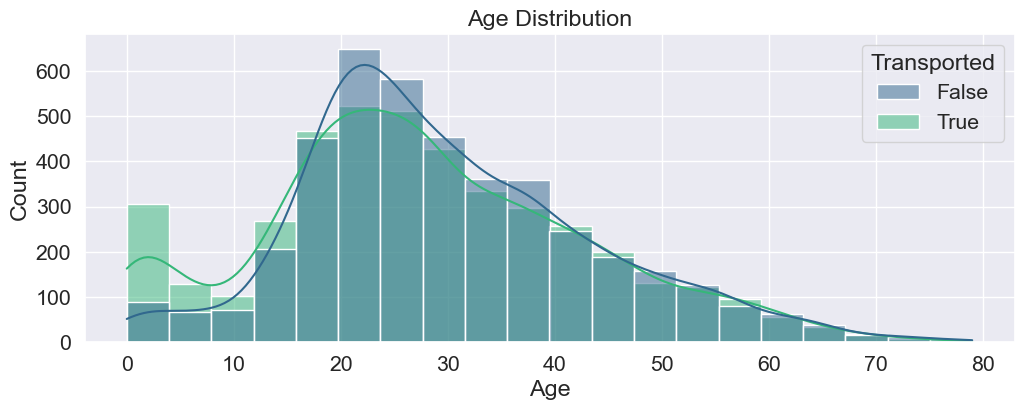

In [39]:
plt.figure(figsize=(12,4))

sns.histplot(data=train, x='Age', hue='Transported', kde=True, bins=20, 
palette='viridis').set_title('Age Distribution').set_label('Age (years)')

*Notes :*
- 0-18 ans sont plus susceptibles d'etres transportés
- 20-38 le sont moins
- 40 ans et + ca n'a pas d'incidence

On peut créer trois catégories, correspondant aux trois classes d'age.

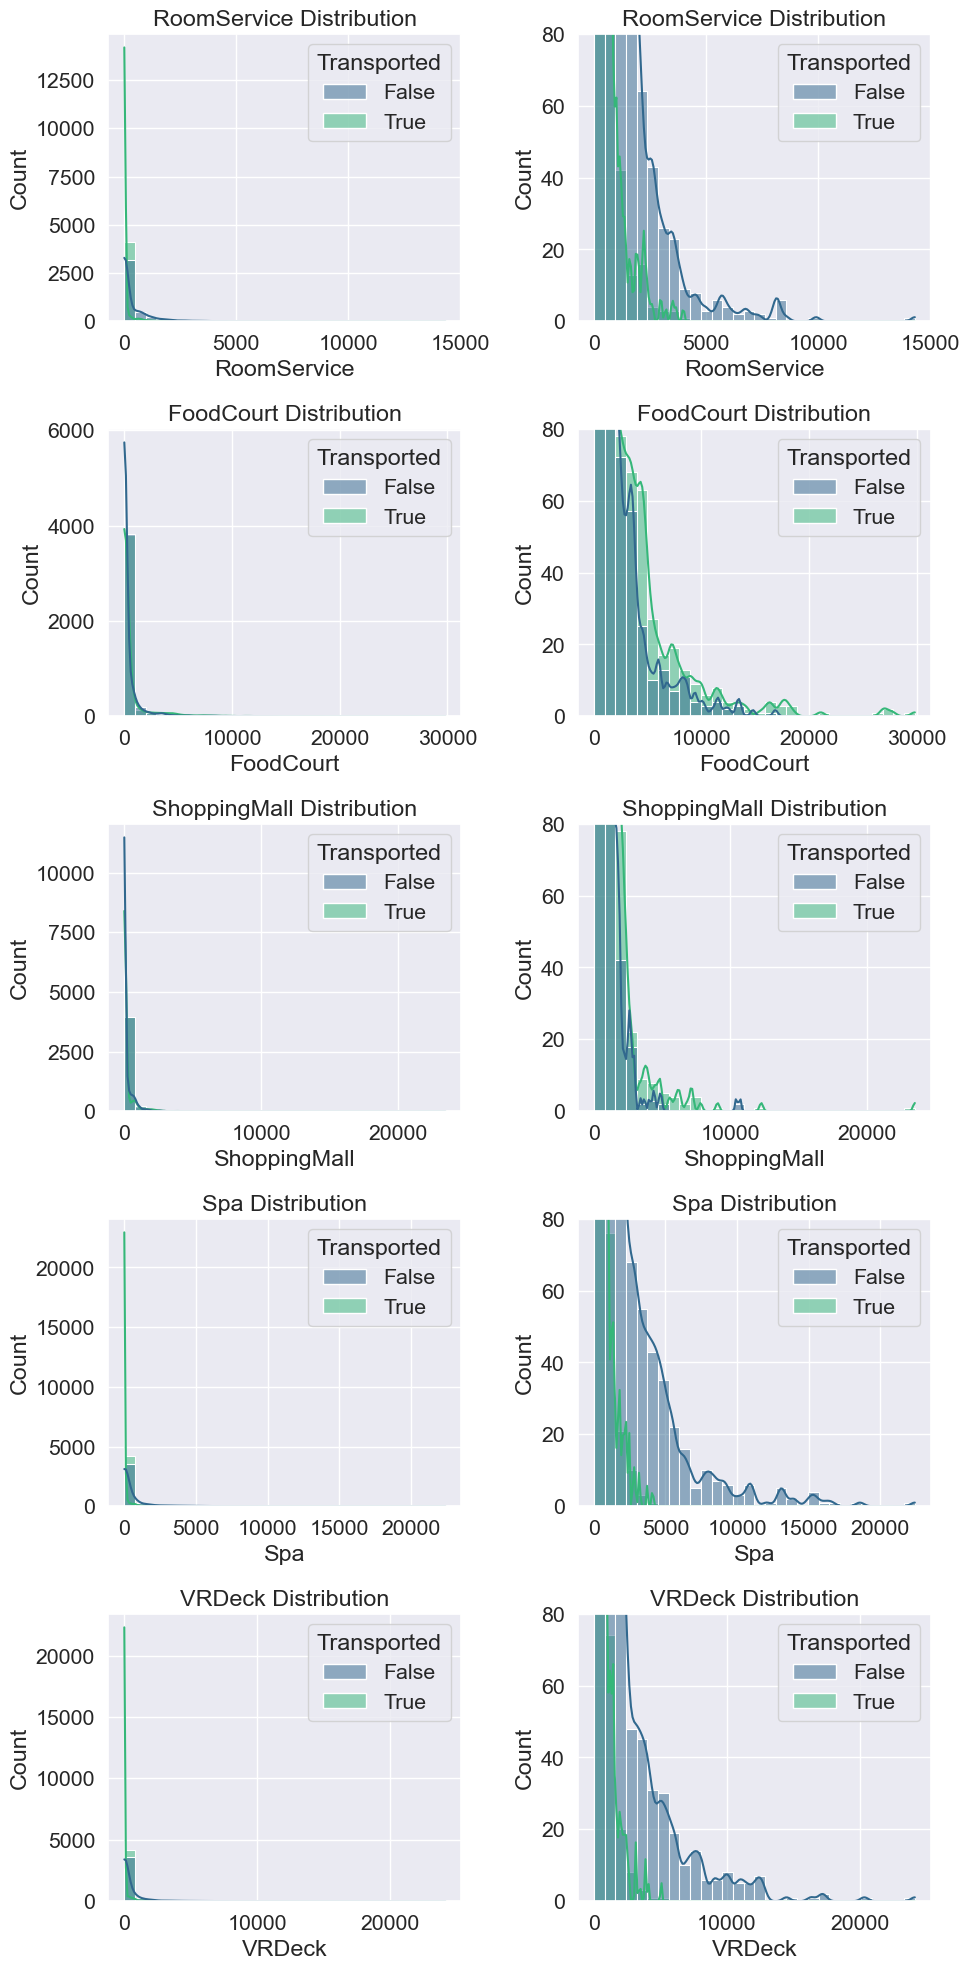

In [40]:
#features liées aux dépenses
depenses = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

fig = plt.figure(figsize=(10, 20))
for i, var_name in enumerate(depenses):
    #Left plot
    ax = fig.add_subplot(5, 2, 2*i+1)
    sns.histplot(data=train, x=var_name, hue='Transported', kde=True, 
    bins=30, palette='viridis')
    ax.set_title(f'{var_name} Distribution')

    #Right plot
    ax = fig.add_subplot(5, 2, 2*i+2)
    sns.histplot(data=train, x=var_name, hue='Transported', kde=True,
    bins=30, palette='viridis')
    plt.ylim([0, 80])
    ax.set_title(f'{var_name} Distribution')

fig.tight_layout()
plt.show()

*Notes*:
- Most people don't spend any money (as we can see on the left).
- The distribution of spending decays exponentially (as we can see on the right).
- There are a small number of outliers.
- People who were transported tended to spend less.
- RoomService, Spa and VRDeck have different distributions to FoodCourt and ShoppingMall - we can think of this as luxury vs essential amenities.

*Insight*:
- Create a new feature that tracks the total expenditure across all 5 amenities.
- Create a binary feature to indicate if the person has not spent anything. (i.e. total expenditure is 0).
- Take the log transform to reduce skew.

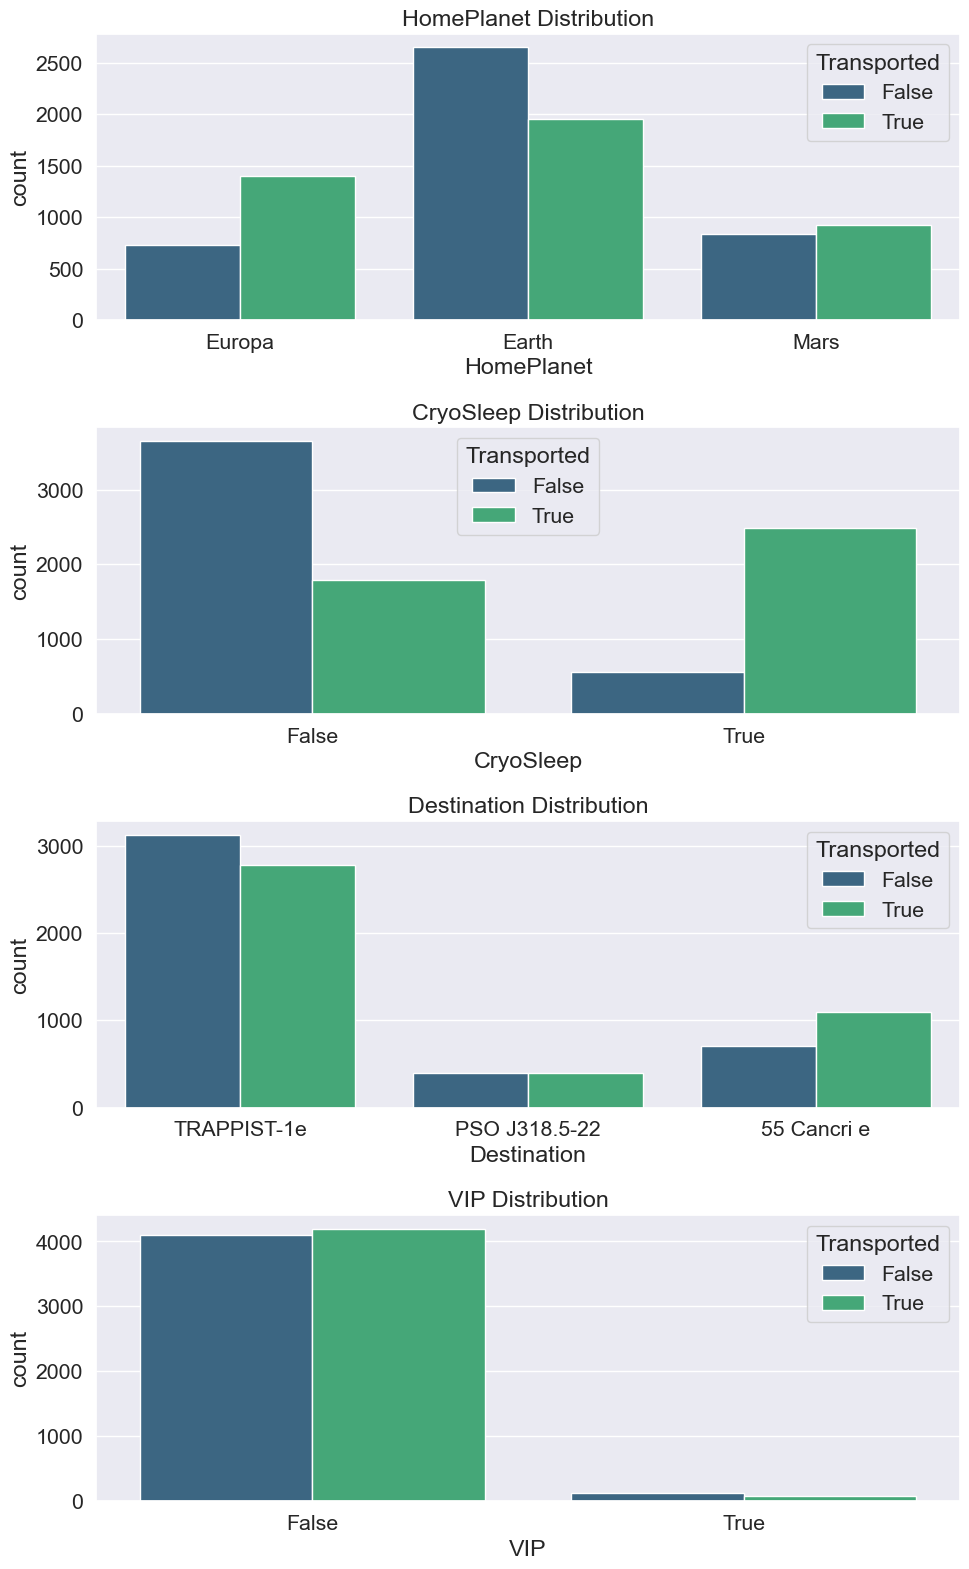

In [41]:
#catégarical features
cat_feats=['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

fig = plt.figure(figsize=(10, 16))
for i, var_name in enumerate(cat_feats):
    ax = fig.add_subplot(4, 1, i+1)
    sns.countplot(data=train, x=var_name, hue='Transported', palette='viridis', axes=ax)
    ax.set_title(f'{var_name} Distribution')
fig.tight_layout()
plt.show()

*Notes*:
- VIP does not appear to be a useful feature; the target split is more or less equal.
- CryoSleep appears the be a very useful feature in contrast.

*Insights*:
- We might consider dropping the VIP column to prevent overfitting.

#### Qualitative Features

On ne peut pas afficher cette data encore, il va falloir la manipuler un peu

In [42]:
qual_feats = ['PassengerId', 'Cabin', 'Name']

train[qual_feats].head(10)

,PassengerId,Cabin,Name
0,0001_01,B/0/P,Maham Ofracculy
1,0002_01,F/0/S,Juanna Vines
2,0003_01,A/0/S,Altark Susent
3,0003_02,A/0/S,Solam Susent
4,0004_01,F/1/S,Willy Santantines
5,0005_01,F/0/P,Sandie Hinetthews
6,0006_01,F/2/S,Billex Jacostaffey
7,0006_02,G/0/S,Candra Jacostaffey
8,0007_01,F/3/S,Andona Beston
9,0008_01,B/1/P,Erraiam Flatic


*Notes*:
- PassengerId takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group.
- Cabin takes the form deck/num/side, where side can be either P for Port or S for Starboard.

Insights:
- We can extract the group and group size from the PassengerId feature.
- We can extract the deck, number and side from the cabin feature.
- We could extract the surname from the name feature to identify families.

### Feature Enginering

Philosophie : de meilleures features font de meilleurs modèles. On va donc, découper, créer, modifier, etc ...

Text(0.5, 1.0, 'Age Group Distribution')

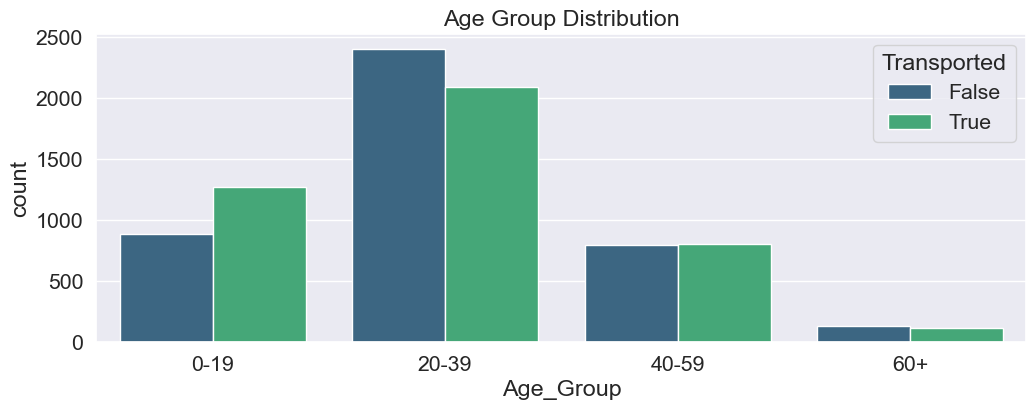

In [43]:
## Essayons par nous meme de refaire le notebook sur les ages

train['Age_Group'] = np.NaN
train.loc[train['Age'] < 20, 'Age_Group'] = '0-19'
train.loc[(train['Age'] >= 20) & (train['Age'] < 40), 'Age_Group'] = '20-39'
train.loc[(train['Age'] >= 40) & (train['Age'] < 60), 'Age_Group'] = '40-59'
train.loc[(train['Age'] >= 60, 'Age_Group')] = '60+'

#dont forget to do the same for the test set
test['Age_Group'] = np.NaN  
test.loc[test['Age'] < 20, 'Age_Group'] = '0-19'
test.loc[(test['Age'] >= 20) & (test['Age'] < 40), 'Age_Group'] = '20-39'
test.loc[(test['Age'] >= 40) & (test['Age'] < 60), 'Age_Group'] = '40-59'
test.loc[(test['Age'] >= 60, 'Age_Group')] = '60+'

plt.figure(figsize=(12,4))
sns.countplot(data=train, x='Age_Group', hue='Transported', order=['0-19', '20-39', '40-59', '60+'],
palette='viridis').set_title('Age Group Distribution')


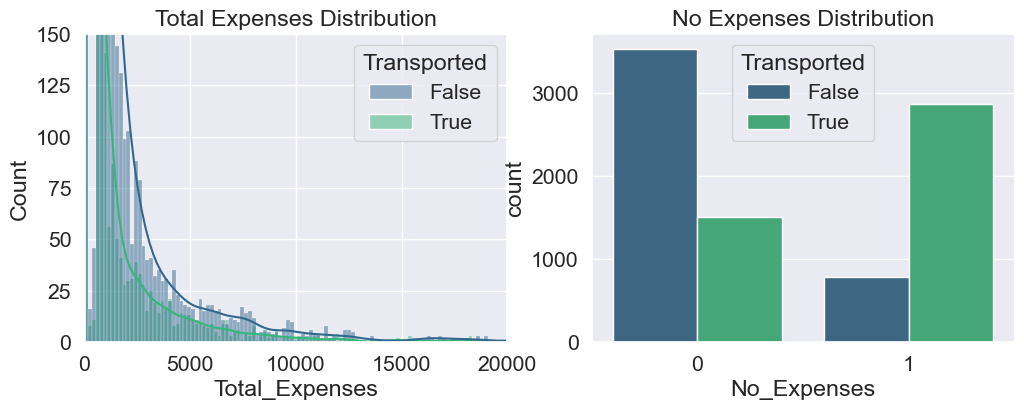

In [44]:
exp_feats = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
train['Total_Expenses'] = train[exp_feats].sum(axis=1)
test['Total_Expenses'] = test[exp_feats].sum(axis=1)

train['No_Expenses'] = (train['Total_Expenses'] == 0).astype(int)
test['No_Expenses'] = (test['Total_Expenses'] == 0).astype(int)

plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
sns.histplot(data=train, x='Total_Expenses', hue='Transported', kde=True, 
bins=200, palette='viridis').set_title('Total Expenses Distribution')
plt.ylim([0,150])
plt.xlim([0,20000])


plt.subplot(1,2,2)
sns.countplot(data=train, x='No_Expenses', hue='Transported', 
palette='viridis').set_title('No Expenses Distribution')
fig.tight_layout()

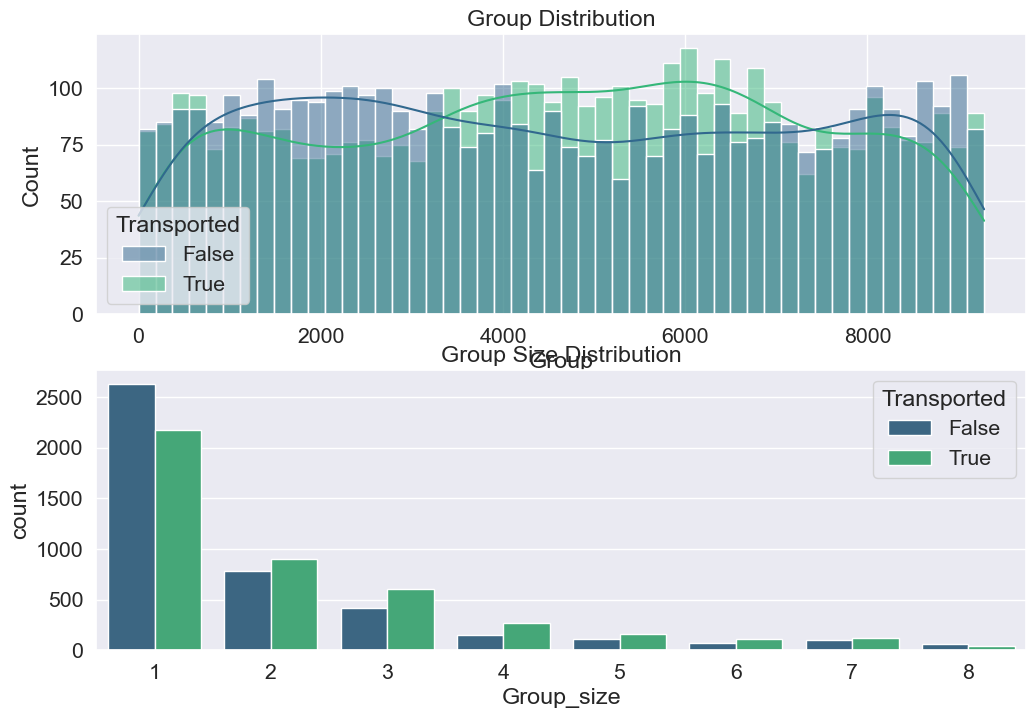

In [45]:
train['Group']=train['PassengerId'].apply(lambda x : x.split('_')[0]).astype(int)
test['Group']=test['PassengerId'].apply(lambda x : x.split('_')[0]).astype(int)

train['Group_size'] = train['Group'].map(lambda x : pd.concat([train['Group'],test['Group']]).value_counts()[x])
test['Group_size'] = test['Group'].map(lambda x : pd.concat([train['Group'],test['Group']]).value_counts()[x])

plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
sns.histplot(data=train, x='Group', hue='Transported', kde=True, bins=50, 
palette='viridis').set_title('Group Distribution')

plt.subplot(2,1,2)
sns.countplot(data=train, x='Group_size', hue='Transported', palette='viridis').set_title('Group Size Distribution')
fig.tight_layout()


Text(0.5, 1.0, 'Solo Distribution')

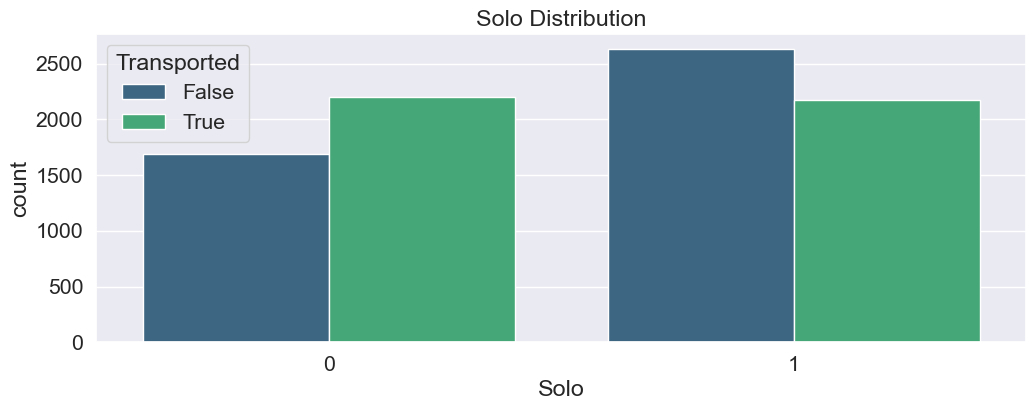

In [46]:
train['Solo'] = (train['Group_size'] == 1).astype(int)
test['Solo'] = (test['Group_size'] == 1).astype(int)

plt.figure(figsize=(12,4))
sns.countplot(data=train, x='Solo', hue='Transported', palette='viridis').set_title('Solo Distribution')

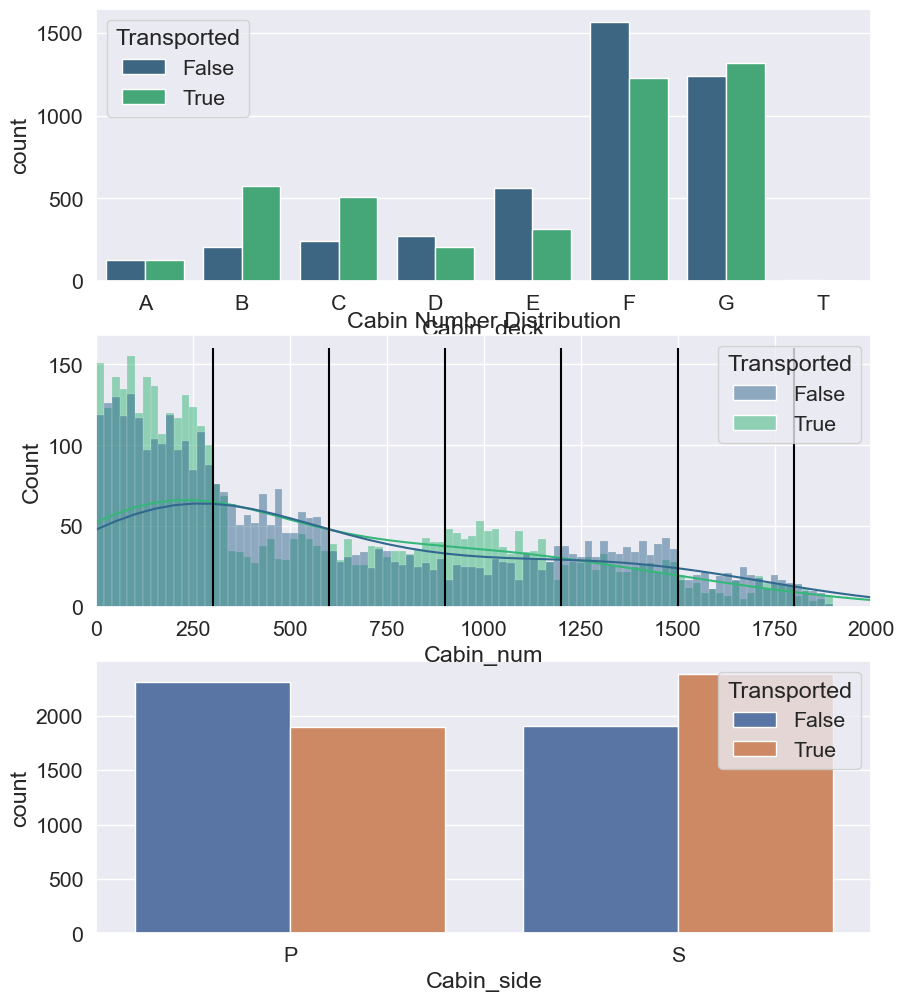

In [47]:
train['Cabin'].fillna('Z/9999/Z', inplace=True)
test['Cabin'].fillna('Z/9999/Z', inplace=True)

train['Cabin_deck'] = train['Cabin'].apply(lambda x : x.split('/')[0])
train['Cabin_num'] = train['Cabin'].apply(lambda x : x.split('/')[1]).astype(int)
train['Cabin_side'] = train['Cabin'].apply(lambda x : x.split('/')[2])

test['Cabin_deck'] = test['Cabin'].apply(lambda x : x.split('/')[0])
test['Cabin_num'] = test['Cabin'].apply(lambda x : x.split('/')[1]).astype(int)
test['Cabin_side'] = test['Cabin'].apply(lambda x : x.split('/')[2])

train.loc[train['Cabin_deck'] == 'Z', 'Cabin_deck'] = np.NaN
test.loc[test['Cabin_deck'] == 'Z', 'Cabin_deck'] = np.NaN
train.loc[train['Cabin_num'] == '9999', 'Cabin_num'] = np.NaN
test.loc[test['Cabin_num'] == '9999', 'Cabin_num'] = np.NaN
train.loc[train['Cabin_side'] == 'Z', 'Cabin_side'] = np.NaN
test.loc[test['Cabin_side'] == 'Z', 'Cabin_side'] = np.NaN

plt.figure(figsize=(10,12))
plt.subplot(3,1,1)
sns.countplot(data=train, x='Cabin_deck', hue='Transported', 
order=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T'],palette='viridis')

plt.subplot(3,1,3)
sns.countplot(data=train, x='Cabin_side', hue='Transported')
fig.tight_layout()

plt.subplot(3,1,2)
sns.histplot(data=train, x='Cabin_num', hue='Transported', kde=True, 
binwidth=20, palette='viridis').set_title('Cabin Number Distribution')
plt.xlim([0, 2000])
plt.vlines(300, ymin=0, ymax=160, color='black')
plt.vlines(600, ymin=0, ymax=160, color='black')
plt.vlines(900, ymin=0, ymax=160, color='black')
plt.vlines(1200, ymin=0, ymax=160, color='black')
plt.vlines(1500, ymin=0, ymax=160, color='black')
plt.vlines(1800, ymin=0, ymax=160, color='black')


In [48]:
train['Cabin_region_1']= (train['Cabin_num'] < 300).astype(int)
train['Cabin_region_2']= ((train['Cabin_num'] >= 300) & (train['Cabin_num'] < 600)).astype(int)
train['Cabin_region_3']= ((train['Cabin_num'] >= 600) & (train['Cabin_num'] < 900)).astype(int)
train['Cabin_region_4']= ((train['Cabin_num'] >= 900) & (train['Cabin_num'] < 1200)).astype(int)
train['Cabin_region_5']= ((train['Cabin_num'] >= 1200) & (train['Cabin_num'] < 1500)).astype(int)
train['Cabin_region_6']= ((train['Cabin_num'] >= 1500) & (train['Cabin_num'] < 1800)).astype(int)
train['Cabin_region_7']= (train['Cabin_num'] >= 1800).astype(int)

test['Cabin_region_1']= (test['Cabin_num'] < 300).astype(int)
test['Cabin_region_2']= ((test['Cabin_num'] >= 300) & (test['Cabin_num'] < 600)).astype(int)
test['Cabin_region_3']= ((test['Cabin_num'] >= 600) & (test['Cabin_num'] < 900)).astype(int)
test['Cabin_region_4']= ((test['Cabin_num'] >= 900) & (test['Cabin_num'] < 1200)).astype(int)
test['Cabin_region_5']= ((test['Cabin_num'] >= 1200) & (test['Cabin_num'] < 1500)).astype(int)
test['Cabin_region_6']= ((test['Cabin_num'] >= 1500) & (test['Cabin_num'] < 1800)).astype(int)
test['Cabin_region_7']= (test['Cabin_num'] >= 1800).astype(int)

#Si on analyse la différence avec la case de code sur l'age par exemple :
#- on utilisait la méthode loc, pour remplir une seule colonne avec différentes valeurs.
#- ici on réalise un One Hot encoding en avance

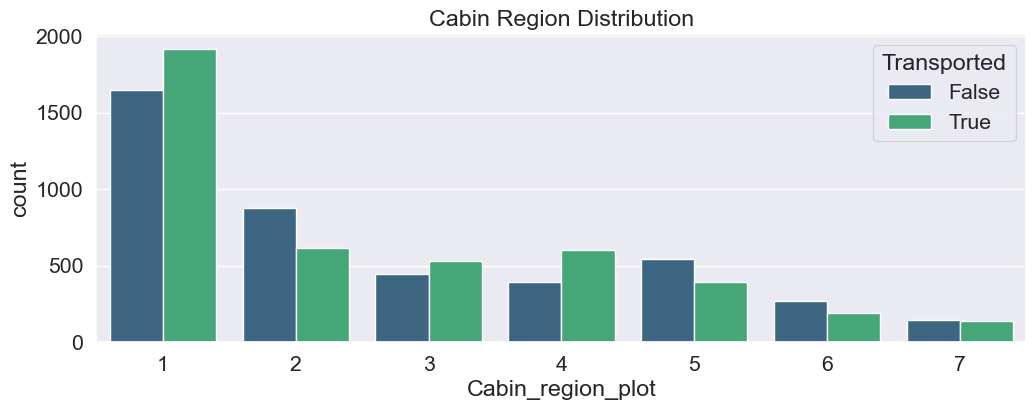

In [49]:
plt.figure(figsize=(12,4))
train['Cabin_region_plot']=(train['Cabin_region_1']*1+train['Cabin_region_2']*2
+train['Cabin_region_3']*3+train['Cabin_region_4']*4+train['Cabin_region_5']*5
+train['Cabin_region_6']*6+train['Cabin_region_7']*7).astype(int)
sns.countplot(data=train, x='Cabin_region_plot', hue='Transported',
palette='viridis').set_title('Cabin Region Distribution')
train.drop('Cabin_region_plot', axis=1, inplace=True)